In [2]:
import Pkg
using Revise
using JLD

In [3]:
using SNNT

In [4]:
using PyCall

In [5]:
using Plots

In [6]:
using LaTeXStrings

In [7]:
pyplot()

Plots.PyPlotBackend()

In [8]:
py"""
import numpy as np
import polytope as pc
from polytope.solvers import lpsolve
def cheby_ball(poly1):
    #logger.debug('cheby ball')
    if (poly1._chebXc is not None) and (poly1._chebR is not None):
        # In case chebyshev ball already calculated and stored
        return poly1._chebR, poly1._chebXc
    if isinstance(poly1, pc.Region):
        maxr = 0
        maxx = None
        for poly in poly1.list_poly:
            rc, xc = cheby_ball(poly)
            if rc > maxr:
                maxr = rc
                maxx = xc
        poly1._chebXc = maxx
        poly1._chebR = maxr
        return maxr, maxx
    if pc.is_empty(poly1):
        return 0, None
    # `poly1` is nonempty
    r = 0
    xc = None
    A = poly1.A
    c = np.negative(np.r_[np.zeros(np.shape(A)[1]), 1])
    norm2 = np.sqrt(np.sum(A * A, axis=1))
    G = np.c_[A, norm2]
    h = poly1.b
    sol = lpsolve(c, G, h)
    #return sol
    if sol['status'] == 0 or (sol['status'] == 4 and pc.is_inside(poly1,sol['x'][0:-1])):
        r = sol['x'][-1]
        if r < 0:
            return 0, None
        xc = sol['x'][0:-1]
    else:
        # Polytope is empty
        poly1 = pc.Polytope(fulldim=False)
        return 0, None
    poly1._chebXc = np.array(xc)
    poly1._chebR = np.double(r)
    return poly1._chebR, poly1._chebXc
"""
cheby_ball = py"cheby_ball"

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


PyObject <function cheby_ball at 0x7f9760032e50>

In [9]:
py"""
import numpy as np
import polytope as pc
def get_extremes(poly1):
    import matplotlib as mpl
    V = pc.extreme(poly1)
    rc, xc = cheby_ball(poly1)
    x = V[:, 1] - xc[1]
    y = V[:, 0] - xc[0]
    mult = np.sqrt(x**2 + y**2)
    x = x / mult
    angle = np.arccos(x)
    corr = np.ones(y.size) - 2 * (y < 0)
    angle = angle * corr
    ind = np.argsort(angle)
    return V[ind, :]
"""
get_extremes = py"get_extremes"

PyObject <function get_extremes at 0x7f9760032d30>

In [10]:
function intersect(pc, p1, p2)
    iA = [p1.A; p2.A]
    ib = append!(p1.b,p2.b)

    return pc.Polytope(iA, ib)
end

function bound_fun(rPos)
    # rPos >= rVel^2 / (2*A)
    # =>
    #rVel = 
    return -sqrt(rPos*2*100)
end

function draw_polygons(ce_list;reuse=false,color=:yellow,boundsfun=true)
    pc = pyimport("polytope")
    first=true
    xpts = range(0.1,100., length=500)
    eps=1.0
    if !reuse
        plot(grid=false)
    end
    for (i, star) in enumerate(ce_list)
        bounds = pc.box2poly([[star.bounds[1][1],star.bounds[1][2]],[star.bounds[2][1],star.bounds[2][2]]])
        p = intersect(pc,pc.Polytope(star.constraint_matrix,star.constraint_bias),bounds)
        drawn = false
        try
            # Manually compute cheby ball because other thing is broken
            cheby_ball(p)
            if pc.is_fulldim(p)
                points = get_extremes(p)
                if first
                    plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])), label="Unsafe",fillcolor = :rosybrown1,linecolor=plot_color(:white, 0.0))
                    first=false
                else
                    plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])), label="",fillcolor = :rosybrown1,linecolor=plot_color(:white, 0.0))
                end
                drawn = true
            else
                #plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])), label="",fillcolor = plot_color(:grey, 0.3))
                println("Empty")
            end
        catch e
            println("Failed")
        end
        if !drawn
            plot!(Shape(
            [star.bounds[1][1],star.bounds[1][1],star.bounds[1][2]+eps,star.bounds[1][2]+eps,star.bounds[1][1]],
            [star.bounds[2][1],star.bounds[2][2]+eps,star.bounds[2][2]eps,star.bounds[2][1],star.bounds[2][1]]),
            label="", fillcolor = :rosybrown1, linecolor=plot_color(:white, 0.0))
        end
    end
    if boundsfun
        return plot!(xpts,bound_fun.(xpts),label="State Space Bound",linecolor=:royalblue3)
    else
        return plot!()
    end
end

draw_polygons (generic function with 1 method)

In [11]:
function plot_acc(file;boundsfun=true)
    acc_data = load(file)
    print(acc_data["args"])
    acc_result = acc_data["result"]
    acc_stars = acc_result.stars
    fig = draw_polygons(acc_stars;boundsfun=boundsfun)
    xaxis!("Position")
    yaxis!("Velocity")
    return fig, acc_result
end

plot_acc (generic function with 1 method)

In [12]:
function get_polytope_list(star_list)
    pc = pyimport("polytope")
    polytope_list = []
    for star in filter(x->x.certain,star_list)
        orig_poly = pc.Polytope(star.constraint_matrix,star.constraint_bias)
        bounds = pc.box2poly(collect(map(x->[x[1],x[2]],star.bounds)))
        orig_poly = intersect(pc,orig_poly,bounds)
        cheby_ball(orig_poly)
        if pc.is_fulldim(orig_poly)
            push!(polytope_list,orig_poly)
        else
            push!(polytope_list,bounds)
        end
    end
    return polytope_list
end
py"""
import pickle
def store_polys(name,polys):
    with open(name,"wb") as f:
        pickle.dump(polys,f)
"""
store_polys = py"store_polys"

PyObject <function store_polys at 0x7f97573ee940>

## Plots

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.10711e-17): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip

Dict{String, Any}("approx" => 1, "linear" => true, "output" => "experiments/acc-3000000-64-64/result-linear.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => true, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-3000000-64-64.onnx", "formula" => "test/parsing/examples/acc/formula", "smt" => "Z3", "smtfilter-timeout" => 10000)Failed


/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.68459e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


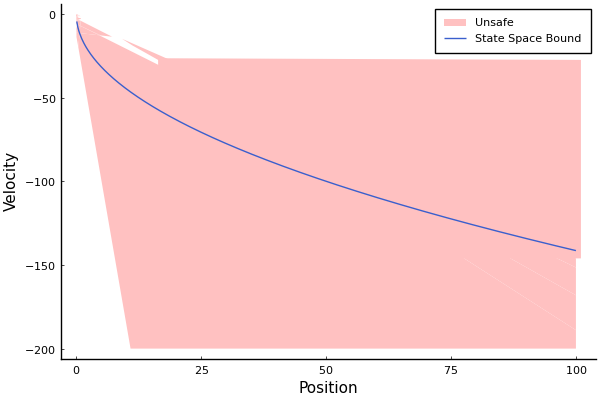

In [68]:
fig_linear, acc_v1_linear = plot_acc("acc-3000000-64-64/result-linear.jld")
fig_linear

In [69]:
savefig(fig_linear,"acc_v1_linear.eps")

Dict{String, Any}("approx" => 1, "linear" => false, "output" => "experiments/acc-3000000-64-64/result-approx1.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => true, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-3000000-64-64.onnx", "formula" => "test/parsing/examples/acc/formula", "smt" => "Z3", "smtfilter-timeout" => 10000)

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.0165e-17): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.

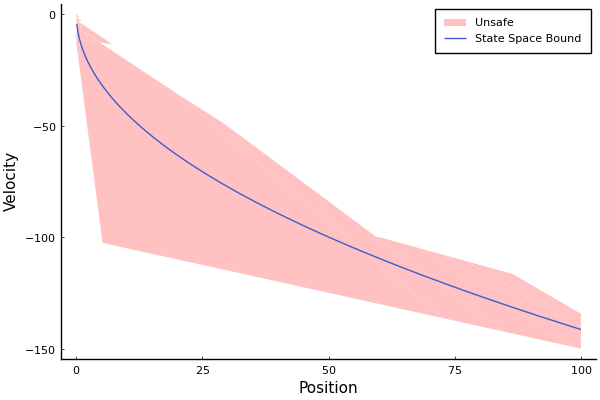

In [70]:
fig_approx1, acc_v1_approx1 = plot_acc("acc-3000000-64-64/result-approx1.jld")
fig_approx1

In [71]:
savefig(fig_approx1,"acc_v1_approx1.eps")

Dict{String, Any}("approx" => 2, "linear" => false, "output" => "experiments/acc-3000000-64-64/result-approx2.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => true, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-3000000-64-64.onnx", "formula" => "test/parsing/examples/acc/formula", "smt" => "Z3", "smtfilter-timeout" => 10000)

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you

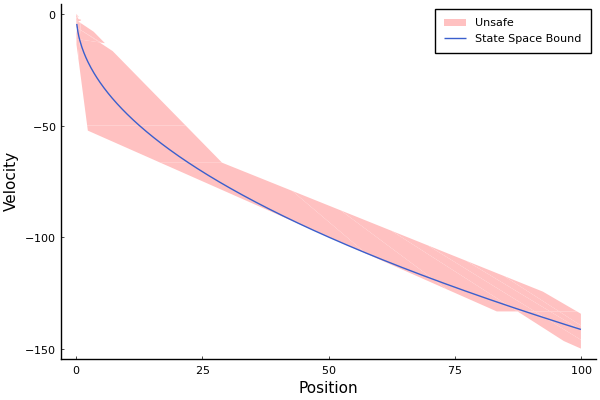

In [72]:
fig_approx2, acc_v1_approx2 = plot_acc("acc-3000000-64-64/result-approx2.jld")
fig_approx2

In [73]:
savefig(fig_approx2,"acc_v1_approx2.eps")

Dict{String, Any}("approx" => 3, "linear" => false, "output" => "experiments/acc-3000000-64-64/result-approx3.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => true, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-3000000-64-64.onnx", "formula" => "test/parsing/examples/acc/formula", "smt" => "Z3", "smtfilter-timeout" => 10000)

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.99944e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip

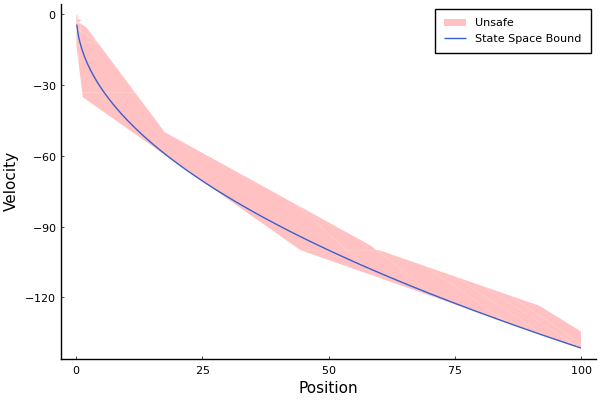

In [74]:
fig_approx3, acc_v1_approx3 = plot_acc("acc-3000000-64-64/result-approx3.jld")
fig_approx3

In [75]:
savefig(fig_approx3,"acc_v1_approx3.eps")

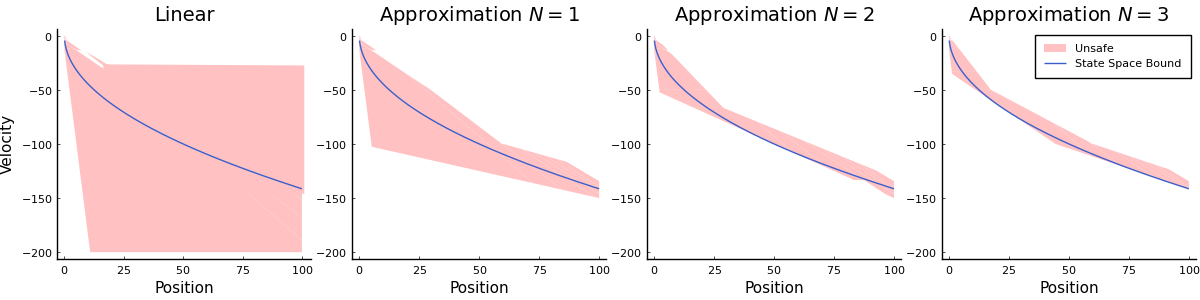

In [76]:
comparison_fig = plot(
    plot(fig_linear,legend_position=nothing,title="Linear"),
    plot(fig_approx1,legend_position=nothing,title="Approximation \$N=1\$",yaxis=""),
    plot(fig_approx2,legend_position=nothing,title="Approximation \$N=2\$",yaxis=""),
    plot(fig_approx3,legend_position=true,title="Approximation \$N=3\$",yaxis=""),
    layout=(1,4),size = (1200, 300),link=:both,left_margin = [0Plots.mm 0Plots.mm])

In [77]:
savefig(comparison_fig,"acc_v1_comparsion.eps")

## Improved NN
For this version the output of the neural network was normalized during training (as well as afterwards) which increases the networks performance after training

Dict{String, Any}("approx" => 1, "linear" => true, "output" => "experiments/acc/acc-improved-2000000-64-64/result-linear.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => true, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-improved-2000000-64-64.onnx", "formula" => "test/parsing/examples/acc/formula", "smt" => "Z3", "smtfilter-timeout" => 10000)

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.27435e-39): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip

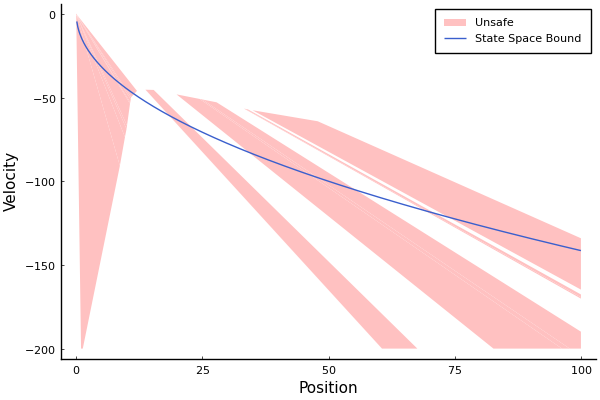

In [52]:
fig_v2_linear, acc_v2_linear = plot_acc("acc-improved-2000000-64-64/result-linear.jld")
fig_v2_linear

In [79]:
savefig(fig_v2_linear,"acc_v2_linear.eps")

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.95471e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: O

Dict{String, Any}("approx" => 1, "linear" => false, "output" => "experiments/acc/acc-improved-2000000-64-64/result-approx1.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => true, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-improved-2000000-64-64.onnx", "formula" => "test/parsing/examples/acc/formula", "smt" => "Z3", "smtfilter-timeout" => 10000)Empty


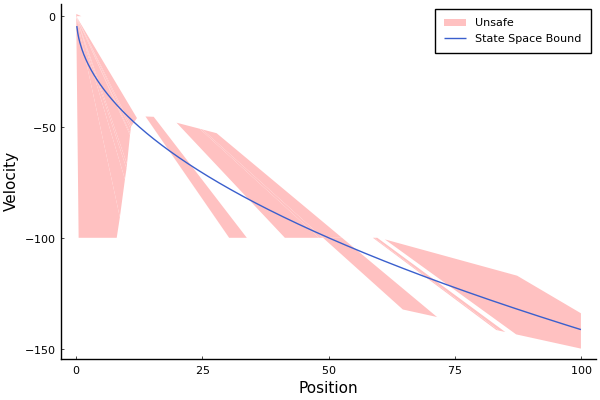

In [53]:
fig_v2_approx1, acc_v2_approx1 = plot_acc("acc-improved-2000000-64-64/result-approx1.jld")
fig_v2_approx1

In [81]:
savefig(fig_v2_approx1,"acc_v2_approx1.eps")

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.10925e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip

Dict{String, Any}("approx" => 2, "linear" => false, "output" => "experiments/acc/acc-improved-2000000-64-64/result-approx2.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => true, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-improved-2000000-64-64.onnx", "formula" => "test/parsing/examples/acc/formula", "smt" => "Z3", "smtfilter-timeout" => 10000)Failed
Empty


/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.25276e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.47888e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


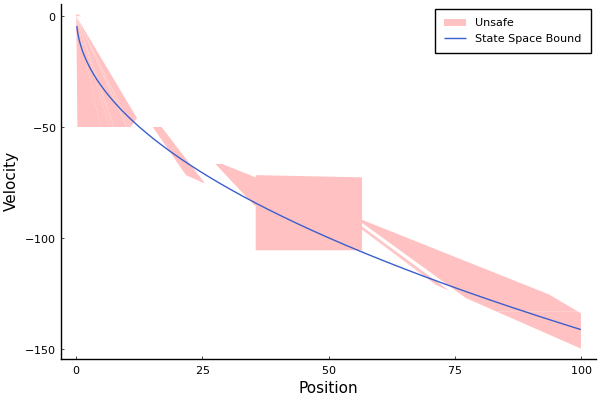

In [54]:
fig_v2_approx2, acc_v2_approx2 = plot_acc("acc-improved-2000000-64-64/result-approx2.jld")
fig_v2_approx2

In [83]:
savefig(fig_v2_approx2,"acc_v2_approx2.eps")

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you

Dict{String, Any}("approx" => 3, "linear" => false, "output" => "experiments/acc/acc-improved-2000000-64-64/result-approx3.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => true, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-improved-2000000-64-64.onnx", "formula" => "test/parsing/examples/acc/formula", "smt" => "Z3", "smtfilter-timeout" => 10000)Empty


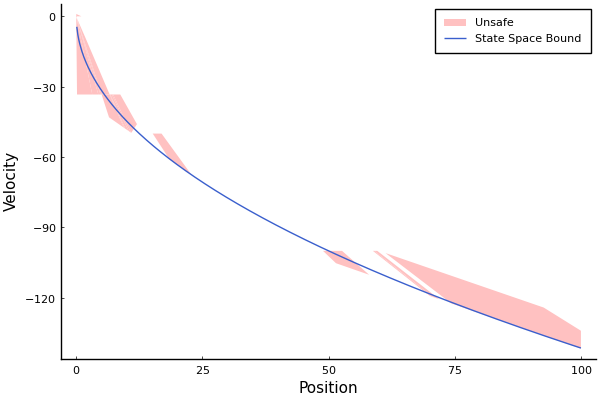

In [55]:
fig_v2_approx3, acc_v2_approx3 = plot_acc("acc-improved-2000000-64-64/result-approx3.jld")
fig_v2_approx3

In [85]:
savefig(fig_v2_approx3,"acc_v2_approx3.eps")

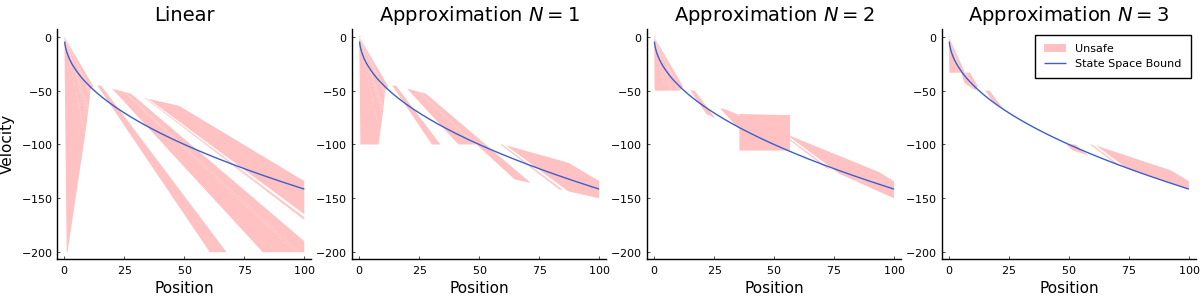

In [86]:
comparison_fig_v2 = plot(
    plot(fig_v2_linear,legend_position=nothing,title="Linear"),
    plot(fig_v2_approx1,legend_position=nothing,title="Approximation \$N=1\$",yaxis=""),
    plot(fig_v2_approx2,legend_position=nothing,title="Approximation \$N=2\$",yaxis=""),
    plot(fig_v2_approx3,legend_position=true,title="Approximation \$N=3\$",yaxis=""),
    layout=(1,4),size = (1200, 300),link=:both,left_margin = [0Plots.mm 0Plots.mm])

In [87]:
savefig(comparison_fig_v2,"acc_v2_comparsion.eps")

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.18724e-40): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.46464e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.02438e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.32094e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.21713e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

Dict{String, Any}("approx" => 1, "linear" => true, "output" => "experiments/acc/acc-2000000-64-64-64-64/result-linear.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => true, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-200000-64-64-64-64.onnx", "formula" => "test/parsing/examples/acc/formula", "smt" => "Z3", "smtfilter-timeout" => 10000)Empty
Empty


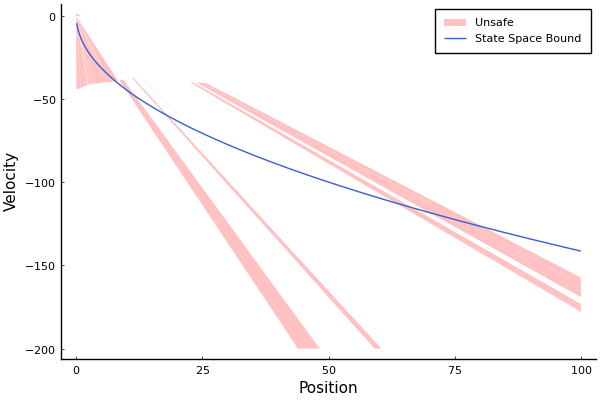

In [56]:
fig_v2_larger_linear, acc_v2_larger_linear = plot_acc("acc-2000000-64-64-64-64/result-linear.jld")
fig_v2_larger_linear

In [89]:
savefig(fig_v2_larger_linear,"acc_v2_larger_linear.eps")

Dict{String, Any}("approx" => 1, "linear" => false, "output" => "experiments/acc/acc-2000000-64-64-64-64/result-approx1.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => true, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-200000-64-64-64-64.onnx", "formula" => "test/parsing/examples/acc/formula", "smt" => "Z3", "smtfilter-timeout" => 10000)

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.43345e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.94795e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.13313e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.50967e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

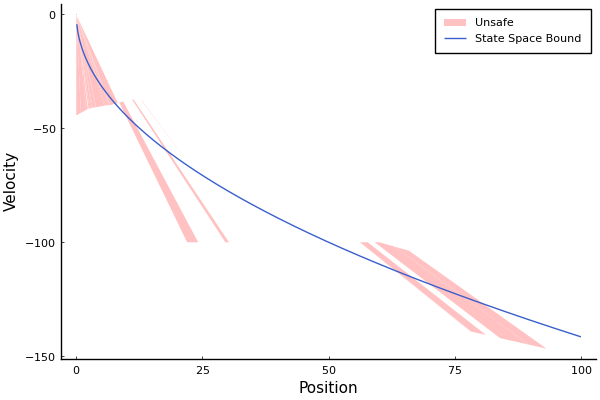

In [57]:
fig_v2_larger_approx1, acc_v2_larger_approx1 = plot_acc("acc-2000000-64-64-64-64/result-approx1.jld")
fig_v2_larger_approx1

In [91]:
savefig(fig_v2_larger_approx1,"acc_v2_larger_approx1.eps")

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.42287e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip

Dict{String, Any}("approx" => 2, "linear" => false, "output" => "experiments/acc/acc-2000000-64-64-64-64/result-approx2.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => true, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-200000-64-64-64-64.onnx", "formula" => "test/parsing/examples/acc/formula", "smt" => "Z3", "smtfilter-timeout" => 10000)Empty


/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.55652e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.02528e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.66925e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.42059e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

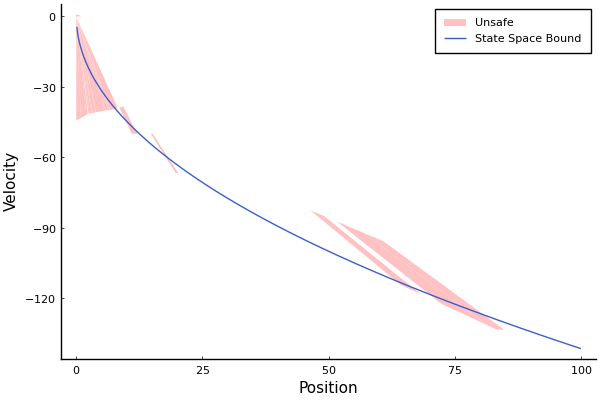

In [58]:
fig_v2_larger_approx2, acc_v2_larger_approx2 = plot_acc("acc-2000000-64-64-64-64/result-approx2.jld")
fig_v2_larger_approx2

In [93]:
savefig(fig_v2_larger_approx2,"acc_v2_larger_approx2.eps")

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.23275e-40): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: O

Dict{String, Any}("approx" => 3, "linear" => false, "output" => "experiments/acc/acc-2000000-64-64-64-64/result-approx3.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => true, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-200000-64-64-64-64.onnx", "formula" => "test/parsing/examples/acc/formula", "smt" => "Z3", "smtfilter-timeout" => 10000)Empty


/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.86109e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


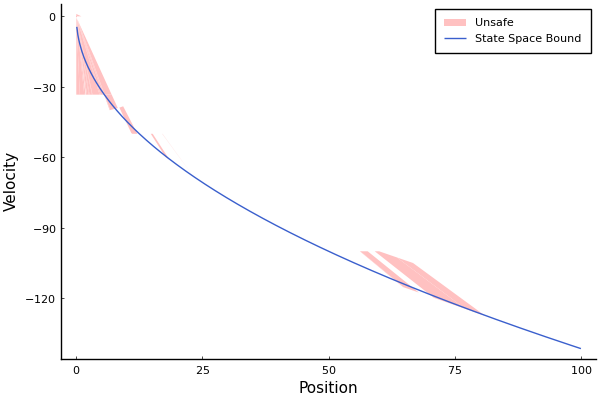

In [59]:
fig_v2_larger_approx3, acc_v2_larger_approx3 = plot_acc("acc-2000000-64-64-64-64/result-approx3.jld")
fig_v2_larger_approx3

In [95]:
savefig(fig_v2_larger_approx3,"acc_v2_larger_approx3.eps")

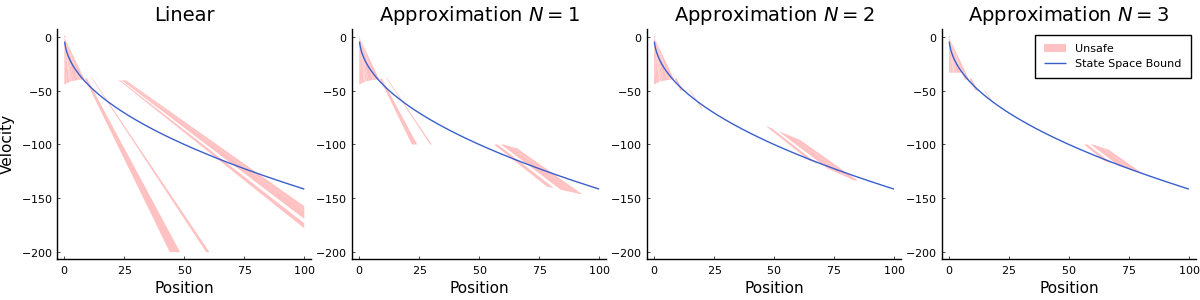

In [96]:
comparison_fig_v2_larger = plot(
    plot(fig_v2_larger_linear,legend_position=nothing,title="Linear"),
    plot(fig_v2_larger_approx1,legend_position=nothing,title="Approximation \$N=1\$",yaxis=""),
    plot(fig_v2_larger_approx2,legend_position=nothing,title="Approximation \$N=2\$",yaxis=""),
    plot(fig_v2_larger_approx3,legend_position=true,title="Approximation \$N=3\$",yaxis=""),
    layout=(1,4),size = (1200, 300),link=:both,left_margin = [0Plots.mm 0Plots.mm])

In [97]:
savefig(comparison_fig_v2_larger,"acc_v2_larger_comparsion.eps")

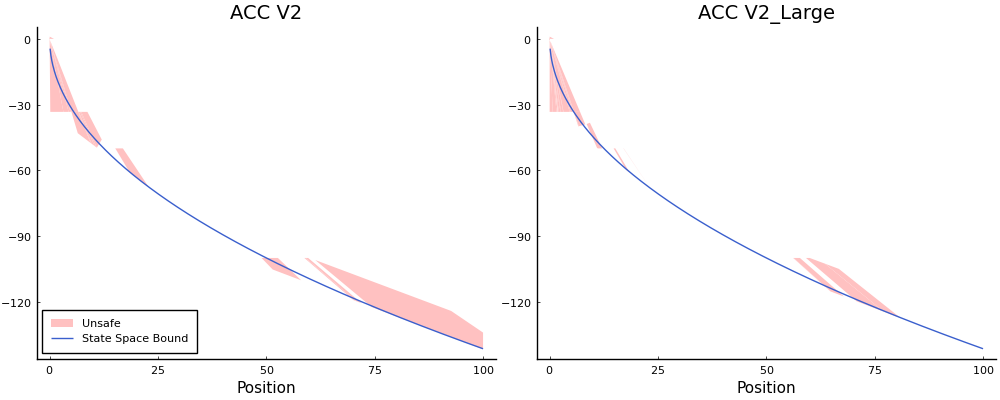

In [60]:
comparison_v2_vs_v2_large = plot(
    plot(fig_v2_approx3,legend_position=:bottomleft,title="ACC V2",yaxis=""),
    plot(fig_v2_larger_approx3,legend_position=false,title="ACC V2_Large",yaxis=""),
    layout=(1,2),size = (1000, 400),link=:both,left_margin = [0Plots.mm 0Plots.mm])

In [61]:
savefig(comparison_v2_vs_v2_large,"acc_v2_vs_v2_large.eps")

In [98]:
py"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Polygon
##### Load and test with onnx
import onnx
import onnxruntime as ort
import numpy as np

observation = np.zeros((1, 2)).astype(np.float32)
def simulate_run(start_state, file, n=3000):
    ort_sess = ort.InferenceSession(file)
    state = start_state
    print(f"Starting with: {state}")
    rPos = [state[0]]
    rVel = [state[1]]
    actions = []
    for i in range(0,n):
        action = ort_sess.run(None, {'input.1': [[state[0],state[1]]]})[0][0]
        #action=100
        actions.append(action)
        t=0.1
        pos_0 = state[0]
        vel_0 = state[1]
        vel = action*t + vel_0
        pos = action*t**2/2 + vel_0*t + pos_0
        state[0]=pos
        state[1]=vel
        rPos.append(state[0])
        rVel.append(state[1])
        if state[0] <= 1 or state[0] > 100:
            if state[0] <= 1:
                print("CRASH")
            break
    return rPos, rVel, actions
"""
simulate_run = py"simulate_run"
function plot_simulation(fig, file, point,label,color,marker)
    pos, vel, actions = simulate_run(point, file)
    print(collect(zip(pos,vel,actions)))
    return plot(fig,pos,vel,linecolor = color,markershape=marker,label=label,markercolor=color)
end

plot_simulation (generic function with 1 method)

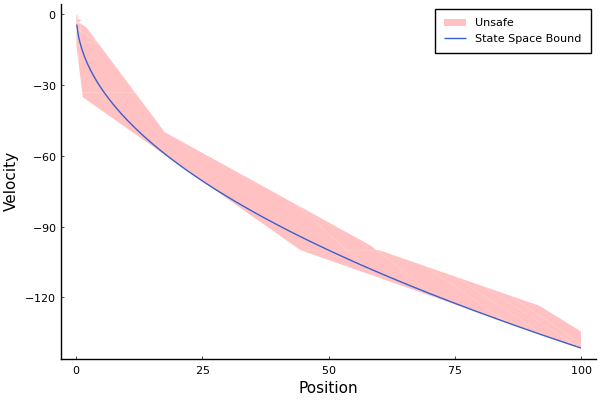

In [99]:
fig_approx3_copy = deepcopy(fig_approx3)

Tuple{Float64, Float64, Vector{Float32}}[(35.0, -74.0, [28.99316]), (27.744964599609375, -71.1006851196289, [29.166574]), (20.780729293823242, -68.18402862548828, [29.268488]), (14.10866928100586, -65.2571792602539, [29.302057]), (7.729461669921875, -62.32697296142578, [29.270441]), (1.6431164741516113, -59.39992904663086, [29.178225])]

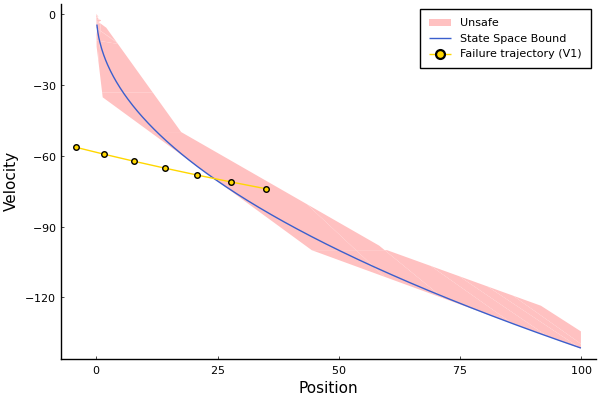

In [100]:
#35.191226959228516, -74.1250228881836
trajectory_plot_v1 = plot_simulation(fig_approx3_copy,"training/all_ppo_acc_3000000_steps.onnx", [35., -74.],"Failure trajectory (V1)",:gold,:circle)

Tuple{Float64, Float64, Vector{Float32}}[(22.0, -64.0, [26.981617]), (15.734908103942871, -61.30183792114258, [27.037384]), (9.739911079406738, -58.59809875488281, [27.031826]), (4.015260219573975, -55.89491653442383, [26.967861])]

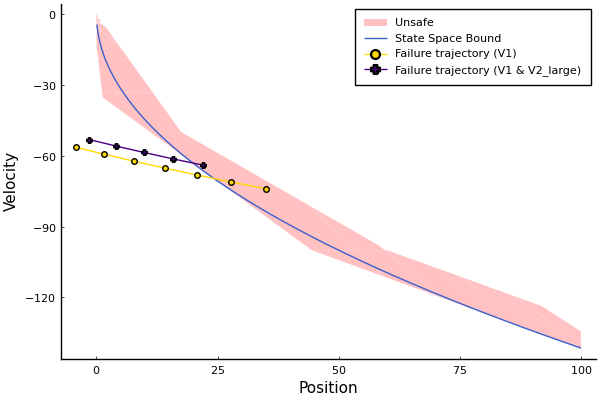

In [101]:
trajectory_plot_v1 = plot_simulation(trajectory_plot_v1,"training/all_ppo_acc_3000000_steps.onnx", [22., -64.],"Failure trajectory (V1 & V2_large)",:indigo,:cross)

Tuple{Float64, Float64, Vector{Float32}}[(76.0, -30.0, [7.435798]), (73.03717803955078, -29.256420135498047, [7.273757]), (70.14790344238281, -28.52904510498047, [7.108985]), (67.3305435180664, -27.818145751953125, [7.047648]), (64.58396911621094, -27.113380432128906, [6.983077]), (61.90754699707031, -26.41507339477539, [6.9154544]), (59.30061721801758, -25.723527908325195, [6.8449583]), (56.762489318847656, -25.039031982421875, [6.7717605]), (54.29244613647461, -24.36185646057129, [6.6960306]), (51.889739990234375, -23.69225311279297, [6.601839]), (49.553524017333984, -23.03207015991211, [6.49106]), (47.282772064208984, -22.382965087890625, [6.3806353]), (45.076377868652344, -21.744901657104492, [6.270996]), (42.93324279785156, -21.117801666259766, [6.1647215]), (40.85228729248047, -20.50132942199707, [6.058983]), (38.83245086669922, -19.895431518554688, [5.953814]), (36.872676849365234, -19.300050735473633, [5.8516994]), (34.97193145751953, -18.714879989624023, [5.752218]), (33.12920

, 0.3263269364833832, [-0.04251668]), (11.085681915283203, 0.3220752775669098, [-0.041971654]), (11.117679595947266, 0.3178781270980835, [-0.041433245]), (11.149260520935059, 0.3137347996234894, [-0.040901512]), (11.180429458618164, 0.3096446394920349, [-0.0403758]), (11.21119213104248, 0.30560705065727234, [-0.03985676]), (11.24155330657959, 0.30162137746810913, [-0.039344102]), (11.27151870727539, 0.29768696427345276, [-0.038837463]), (11.301093101501465, 0.29380321502685547, [-0.03833732]), (11.330282211303711, 0.28996947407722473, [-0.03784296]), (11.359089851379395, 0.2861851751804352, [-0.037354916]), (11.387521743774414, 0.2824496924877167, [-0.036872834]), (11.415582656860352, 0.2787624001502991, [-0.03639677]), (11.443277359008789, 0.275122731924057, [-0.03592667]), (11.470609664916992, 0.27153006196022034, [-0.03546217]), (11.49758529663086, 0.2679838538169861, [-0.035003334]), (11.524209022521973, 0.2644835114479065, [-0.034550577]), (11.550484657287598, 0.2610284686088562, 

]), (13.284299850463867, 0.03249509260058403, [-0.004259467]), (13.287528038024902, 0.03206914663314819, [-0.004203856]), (13.290714263916016, 0.03164876252412796, [-0.004148513]), (13.293858528137207, 0.031233910471200943, [-0.004094273]), (13.296961784362793, 0.030824482440948486, [-0.0040403903]), (13.300024032592773, 0.030420443043112755, [-0.00398764]), (13.303046226501465, 0.030021678656339645, [-0.0039352477]), (13.306028366088867, 0.029628153890371323, [-0.0038836002]), (13.308971405029297, 0.029239794239401817, [-0.0038326383]), (13.31187629699707, 0.028856530785560608, [-0.0037824512]), (13.314743041992188, 0.028478285297751427, [-0.0037329197]), (13.317572593688965, 0.02810499258339405, [-0.0036838353]), (13.320364952087402, 0.027736609801650047, [-0.0036357641]), (13.3231201171875, 0.02737303264439106, [-0.0035880208]), (13.325839042663574, 0.0270142313092947, [-0.003541112]), (13.328522682189941, 0.026660120114684105, [-0.003494531]), (13.331171035766602, 0.026310667395591

]), (13.504094123840332, 0.0034943579230457544, [-0.0004581213]), (13.504441261291504, 0.0034485456999391317, [-0.00045219064]), (13.504783630371094, 0.003403326729312539, [-0.00044623017]), (13.505122184753418, 0.0033587038051337004, [-0.0004402995]), (13.50545597076416, 0.003314673900604248, [-0.00043472648]), (13.50578498840332, 0.0032712011598050594, [-0.000428766]), (13.506110191345215, 0.0032283244654536247, [-0.00042310357]), (13.506430625915527, 0.0031860140152275562, [-0.00041770935]), (13.506747245788574, 0.0031442430336028337, [-0.00041225553]), (13.507060050964355, 0.0031030175741761923, [-0.0004068613]), (13.507368087768555, 0.003062331350520253, [-0.0004016161]), (13.507672309875488, 0.0030221696943044662, [-0.00039613247]), (13.507972717285156, 0.002982556354254484, [-0.00039091706]), (13.508269309997559, 0.0029434645548462868, [-0.00038596988]), (13.508562088012695, 0.002904867520555854, [-0.0003809631]), (13.508851051330566, 0.0028667713049799204, [-0.0003758967]), (13

, 0.00039594704867340624, [-5.1915646f-5]), (13.527613639831543, 0.00039075547829270363, [-5.1230192f-5]), (13.527652740478516, 0.0003856324474327266, [-5.0634146f-5]), (13.527690887451172, 0.000380569021217525, [-4.9859285f-5]), (13.527729034423828, 0.00037558309850282967, [-4.929304f-5]), (13.527766227722168, 0.0003706537827383727, [-4.8547983f-5]), (13.527803421020508, 0.00036579897277988493, [-4.7892332f-5]), (13.527839660644531, 0.0003610097337514162, [-4.7385693f-5]), (13.527875900268555, 0.00035627116449177265, [-4.6610832f-5]), (13.527911186218262, 0.0003516100696288049, [-4.607439f-5]), (13.527946472167969, 0.0003470026422291994, [-4.5329332f-5]), (13.52798080444336, 0.00034246972063556314, [-4.476309f-5]), (13.52801513671875, 0.0003379934059921652, [-4.425645f-5]), (13.528048515319824, 0.00033356776111759245, [-4.3809414f-5]), (13.528081893920898, 0.00032918681972660124, [-4.324317f-5]), (13.528114318847656, 0.00032486251438967884, [-4.2647123f-5]), (13.528146743774414, 0.000

 [-5.811453f-6]), (13.530244827270508, 4.3740168621297926e-5, [-5.841255f-6]), (13.53024959564209, 4.315604383009486e-5, [-5.6922436f-6]), (13.530253410339355, 4.258682020008564e-5, [-5.751848f-6]), (13.530257225036621, 4.20116339228116e-5, [-5.5730343f-6]), (13.530261039733887, 4.145433194935322e-5, [-5.364418f-6]), (13.530264854431152, 4.09178901463747e-5, [-5.4240227f-6]), (13.530268669128418, 4.037548933411017e-5, [-5.155802f-6]), (13.530272483825684, 3.985990770161152e-5, [-5.1259995f-6]), (13.53027629852295, 3.934730921173468e-5, [-5.066395f-6]), (13.530280113220215, 3.884066973114386e-5, [-5.2154064f-6]), (13.53028392791748, 3.8319129089359194e-5, [-4.9471855f-6]), (13.530287742614746, 3.782441126531921e-5, [-5.0365925f-6]), (13.530291557312012, 3.73207512893714e-5, [-4.7385693f-6]), (13.530295372009277, 3.6846893635811284e-5, [-4.887581f-6]), (13.530299186706543, 3.635813482105732e-5, [-4.827976f-6]), (13.530303001403809, 3.587533865356818e-5, [-4.8577785f-6]), (13.530306816101

, 4.293814981792821e-6, [-8.046627f-7]), (13.530545234680176, 4.2133488022955135e-6, [-8.046627f-7]), (13.530545234680176, 4.132882622798206e-6, [-8.046627f-7]), (13.530545234680176, 4.052416443300899e-6, [-6.2584877f-7]), (13.530545234680176, 3.989831384387799e-6, [-5.9604645f-7]), (13.530545234680176, 3.930226739612408e-6, [-5.9604645f-7]), (13.530545234680176, 3.870622094837017e-6, [-5.066395f-7]), (13.530545234680176, 3.8199582377274055e-6, [-4.172325f-7]), (13.530545234680176, 3.778234940909897e-6, [-4.172325f-7]), (13.530545234680176, 3.7365116440923885e-6, [-4.172325f-7]), (13.530545234680176, 3.69478834727488e-6, [-3.5762787f-7]), (13.530545234680176, 3.6590256513591157e-6, [-2.9802322f-7]), (13.530545234680176, 3.6292233289714204e-6, [-2.682209f-7]), (13.530545234680176, 3.6024011933477595e-6, [-2.682209f-7]), (13.530545234680176, 3.5755790577240987e-6, [-2.682209f-7]), (13.530545234680176, 3.548756922100438e-6, [-2.0861626f-7]), (13.530545234680176, 3.5278953873785213e-6, [-2

 [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6,

 [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6,

 [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6,

 [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6,

 [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6,

 [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6,

 [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6,

 [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6,

 [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6, [0.0]), (13.530545234680176, 3.14940552925691e-6,

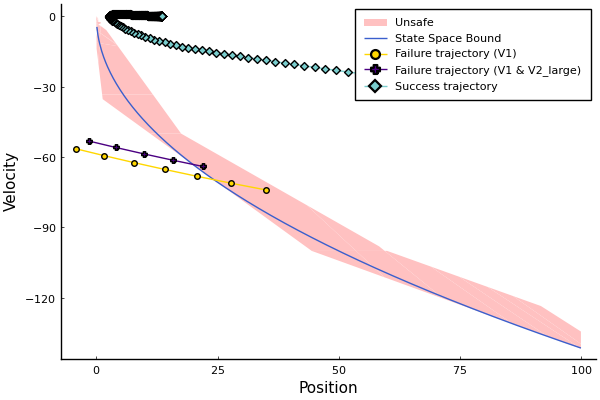

In [102]:
trajectory_plot_v1 = plot_simulation(trajectory_plot_v1,"training/all_ppo_acc_3000000_steps.onnx", [76.,-30.],"Success trajectory",:darkslategray3,:diamond)

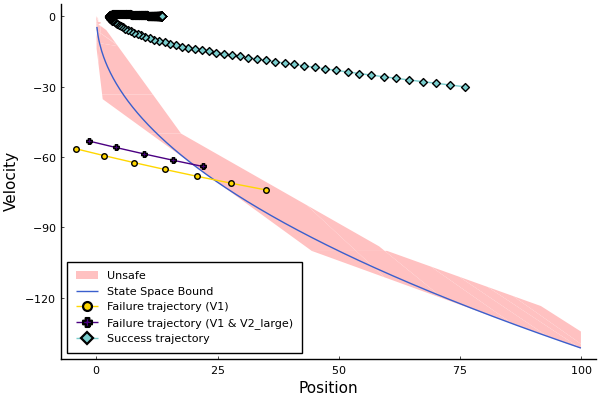

In [103]:
trajectory_plot_v1 = plot(trajectory_plot_v1,legend_position=:bottomleft)

In [104]:
savefig(trajectory_plot_v1,"acc_v1_trajectory.eps")

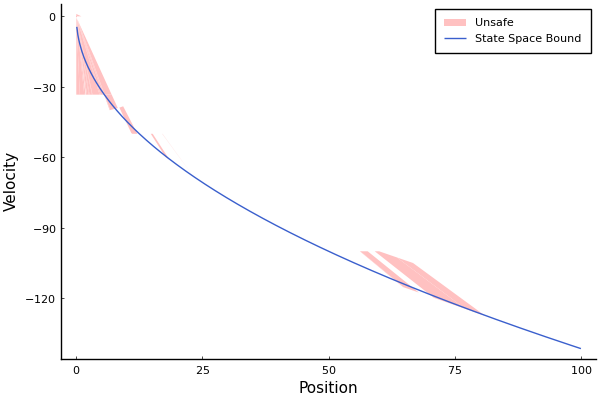

In [105]:
fig_v2_larger_approx3_copy = deepcopy(fig_v2_larger_approx3)

Tuple{Float64, Float64, Vector{Float32}}[(35.0, -74.0, [100.00001]), (28.100000381469727, -64.0, [100.00001]), (22.200000762939453, -54.0, [100.00001]), (17.30000114440918, -44.0, [100.0]), (13.400001525878906, -34.0, [89.73825]), (10.448692321777344, -25.026174545288086, [69.406784]), (8.293108940124512, -18.085494995117188, [53.664387]), (6.752881050109863, -12.719056129455566, [41.806774]), (5.690009117126465, -8.538378715515137, [32.637417]), (4.999358177185059, -5.274637222290039, [23.9163]), (4.591475963592529, -2.883007287979126, [15.119964]), (4.378775119781494, -1.3710108995437622, [14.224398]), (4.312796115875244, 0.051428914070129395, [13.9108]), (4.387493133544922, 1.4425089359283447, [13.206042]), (4.597774028778076, 2.763113021850586, [12.475172]), (4.936461448669434, 4.010630130767822, [11.97078]), (5.397378444671631, 5.207708358764648, [11.879718]), (5.977547645568848, 6.3956804275512695, [11.140812]), (6.6728196144104, 7.509761810302734, [10.390343]), (7.47574758529663

, -0.19999289512634277, [0.112621486]), (87.95033264160156, -0.18873074650764465, [0.10969192]), (87.9320068359375, -0.17776155471801758, [0.10674298]), (87.91476440429688, -0.16708725690841675, [0.10377169]), (87.89857482910156, -0.15671008825302124, [0.100791454]), (87.88340759277344, -0.14663094282150269, [0.09779781]), (87.86923217773438, -0.13685116171836853, [0.09481013]), (87.85601806640625, -0.12737014889717102, [0.091820955]), (87.84374237060547, -0.1181880533695221, [0.08884221]), (87.83236694335938, -0.10930383205413818, [0.08587092]), (87.82186889648438, -0.1007167398929596, [0.082919]), (87.81221008300781, -0.09242483973503113, [0.07998943]), (87.8033676147461, -0.0844258964061737, [0.07708073]), (87.7953109741211, -0.07671782374382019, [0.07421523]), (87.78800964355469, -0.06929630041122437, [0.07136464]), (87.78143310546875, -0.062159836292266846, [0.06855279]), (87.77555847167969, -0.05530455708503723, [0.065782666]), (87.77035522460938, -0.048726290464401245, [0.063049

]), (87.9929428100586, -0.002194136381149292, [0.00049620867]), (87.99272918701172, -0.0021445155143737793, [0.00050216913]), (87.99251556396484, -0.0020942986011505127, [0.0005096197]), (87.9923095703125, -0.0020433366298675537, [0.00052154064]), (87.99211120605469, -0.001991182565689087, [0.00052303076]), (87.99191284179688, -0.0019388794898986816, [0.00053048134]), (87.9917221069336, -0.001885831356048584, [0.00053048134]), (87.99153900146484, -0.0018327832221984863, [0.0005349517]), (87.9913558959961, -0.0017792880535125732, [0.00053048134]), (87.99118041992188, -0.0017262399196624756, [0.00053197145]), (87.99101257324219, -0.0016730427742004395, [0.00053048134]), (87.9908447265625, -0.0016199946403503418, [0.00053197145]), (87.99068450927734, -0.0015667974948883057, [0.00053048134]), (87.99053192138672, -0.001513749361038208, [0.0005275011]), (87.99038696289062, -0.0014609992504119873, [0.00052303076]), (87.99024200439453, -0.001408696174621582, [0.0005185604]), (87.99010467529297

]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.9439

 [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6

 [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6

 [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6

 [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6

 [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6

 [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6

 [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6

 [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6

 [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6

 [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6

 [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6

 [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6.943941116333008e-6, [0.0]), (87.98873901367188, -6

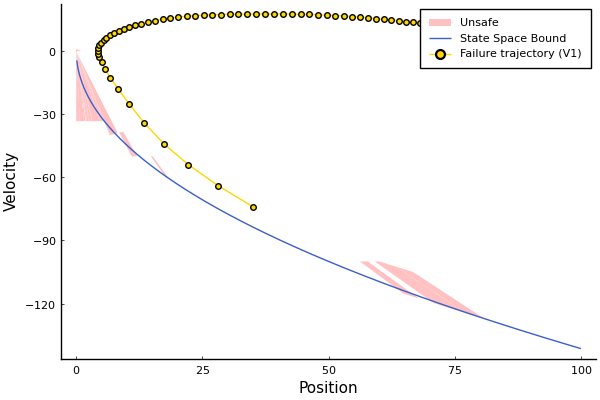

In [106]:
trajectory_plot_v2_large = plot_simulation(fig_v2_larger_approx3_copy,"training/ppo_acc_bigger_200000_steps.onnx", [35., -74.],"Failure trajectory (V1)",:gold,:circle)

Tuple{Float64, Float64, Vector{Float32}}[(22.0, -64.0, [99.99999]), (16.100000381469727, -54.0, [100.0]), (11.200000762939453, -44.0, [100.0]), (7.3000006675720215, -34.0, [89.16406]), (4.345820903778076, -25.083593368530273, [68.49725]), (2.179947853088379, -18.233867645263672, [53.267937])]

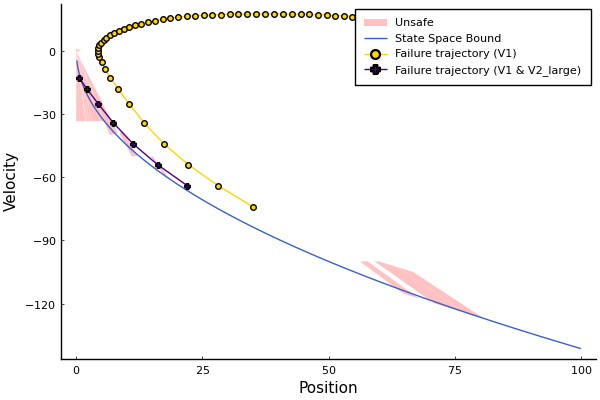

In [107]:
trajectory_plot_v2_large = plot_simulation(trajectory_plot_v2_large,"training/ppo_acc_bigger_200000_steps.onnx", [22., -64.],"Failure trajectory (V1 & V2_large)",:indigo,:cross)

Tuple{Float64, Float64, Vector{Float32}}[(76.0, -30.0, [6.8348064]), (73.03417205810547, -29.316518783569336, [7.0530386]), (70.13778686523438, -28.611215591430664, [7.272159]), (67.31302642822266, -27.88399887084961, [7.494101]), (64.56209564208984, -27.13458824157715, [7.714395]), (61.88720703125, -26.363149642944336, [7.935568]), (59.29056930541992, -25.56959342956543, [8.15859]), (56.7744026184082, -24.753734588623047, [8.383428]), (54.340946197509766, -23.91539192199707, [8.610055]), (51.99245834350586, -23.054386138916016, [8.838436]), (49.7312126159668, -22.170541763305664, [9.068542]), (47.55950164794922, -21.263687133789062, [9.300339]), (45.47963333129883, -20.33365249633789, [9.533784]), (43.49393844604492, -19.380273818969727, [9.768844]), (41.60475540161133, -18.40338897705078, [10.00548]), (39.81444549560547, -17.402841567993164, [10.243658]), (38.12538146972656, -16.378475189208984, [10.483338]), (36.53995132446289, -15.330141067504883, [10.724471]), (35.0605583190918, -

, -0.33328527212142944, [0.06786138]), (88.64334869384766, -0.3264991343021393, [0.06964058]), (88.61104583740234, -0.3195350766181946, [0.07120967]), (88.5794448852539, -0.31241410970687866, [0.072582066]), (88.54856872558594, -0.3051559031009674, [0.0737533]), (88.51842498779297, -0.2977805733680725, [0.074735284]), (88.48902130126953, -0.29030704498291016, [0.07554293]), (88.46036529541016, -0.28275275230407715, [0.07618368]), (88.4324722290039, -0.2751343846321106, [0.076659024]), (88.40534210205078, -0.26746848225593567, [0.07698983]), (88.37898254394531, -0.2597694993019104, [0.07716268]), (88.3533935546875, -0.25205323100090027, [0.077202916]), (88.32857513427734, -0.2443329393863678, [0.07711053]), (88.30452728271484, -0.2366218864917755, [0.0769034]), (88.28125, -0.22893154621124268, [0.07656664]), (88.25874328613281, -0.22127488255500793, [0.07612258]), (88.23699951171875, -0.21366262435913086, [0.07558018]), (88.21601104736328, -0.2061046063899994, [0.07494241]), (88.1957778

 [-0.0004246831]), (87.99481201171875, -0.0011534392833709717, [-0.00038146973]), (87.99469757080078, -0.0011915862560272217, [-0.00034868717]), (87.99457550048828, -0.0012264549732208252, [-0.0003054738]), (87.99445343017578, -0.0012570023536682129, [-0.00026673079]), (87.99432373046875, -0.0012836754322052002, [-0.00022649765]), (87.99419403076172, -0.0013063251972198486, [-0.00020265579]), (87.99406433105469, -0.0013265907764434814, [-0.00016540289]), (87.99393463134766, -0.0013431310653686523, [-0.00013560057]), (87.9937973022461, -0.0013566911220550537, [-0.000101327896]), (87.99365997314453, -0.0013668239116668701, [-7.748604f-5]), (87.99352264404297, -0.001374572515487671, [-4.9173832f-5]), (87.9933853149414, -0.0013794898986816406, [-1.937151f-5]), (87.99324798583984, -0.0013814270496368408, [1.4901161f-6]), (87.99311065673828, -0.0013812780380249023, [1.937151f-5]), (87.99297332763672, -0.0013793408870697021, [4.4703484f-5]), (87.99283599853516, -0.0013748705387115479, [6.5565

]), (87.98870849609375, 1.1086463928222656e-5, [-4.4703484f-6]), (87.98870849609375, 1.0639429092407227e-5, [-4.4703484f-6]), (87.98870849609375, 1.0192394256591797e-5, [-2.9802322f-6]), (87.98870849609375, 9.894371032714844e-6, [-2.9802322f-6]), (87.98870849609375, 9.59634780883789e-6, [-2.9802322f-6]), (87.98870849609375, 9.298324584960938e-6, [-2.9802322f-6]), (87.98870849609375, 9.000301361083984e-6, [-2.9802322f-6]), (87.98870849609375, 8.702278137207031e-6, [-4.4703484f-6]), (87.98870849609375, 8.255243301391602e-6, [-4.4703484f-6]), (87.98870849609375, 7.808208465576172e-6, [-2.9802322f-6]), (87.98870849609375, 7.510185241699219e-6, [-2.9802322f-6]), (87.98870849609375, 7.212162017822266e-6, [-2.9802322f-6]), (87.98870849609375, 6.9141387939453125e-6, [-5.9604645f-6]), (87.98870849609375, 6.318092346191406e-6, [-2.9802322f-6]), (87.98870849609375, 6.020069122314453e-6, [-2.9802322f-6]), (87.98870849609375, 5.7220458984375e-6, [-2.9802322f-6]), (87.98870849609375, 5.4240226745605

]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-

, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98

 [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.2319297

]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1

, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.988

 [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.38094139

]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-

, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98

 [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.2319297

]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1

, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.988

 [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.38094139

]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-

, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98870849609375, 4.231929779052734e-6, [1.4901161f-6]), (87.98870849609375, 4.380941390991211e-6, [-1.4901161f-6]), (87.98

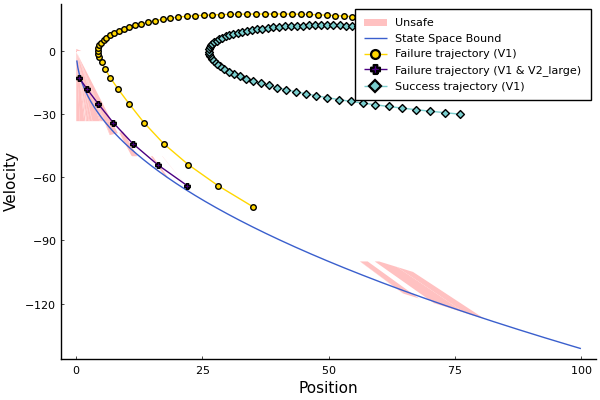

In [108]:
trajectory_plot_v2_large = plot_simulation(trajectory_plot_v2_large,"training/ppo_acc_bigger_200000_steps.onnx", [76.,-30.],"Success trajectory (V1)",:darkslategray3,:diamond)

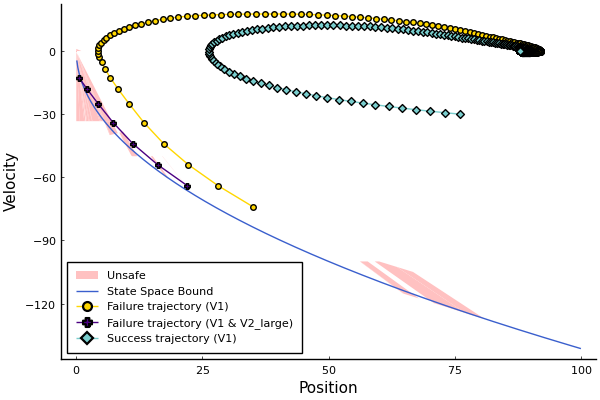

In [109]:
trajectory_plot_v2_large = plot(trajectory_plot_v2_large,legend_position=:bottomleft)

In [110]:
savefig(trajectory_plot_v2_large,"acc_v2_larger_trajectory.eps")

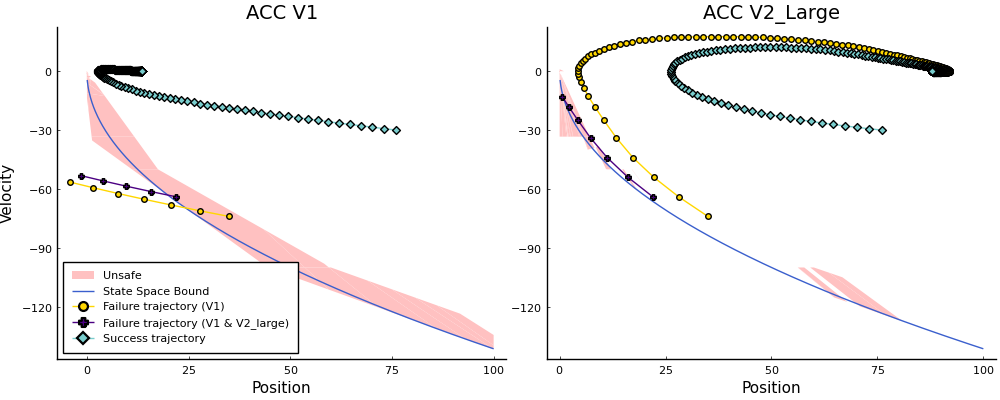

In [111]:
comparison_fig = plot(
    plot(trajectory_plot_v1,legend_position=:bottomleft,title="ACC V1"),
    plot(trajectory_plot_v2_large,legend_position=false,title="ACC V2_Large",yaxis=""),
    layout=(1,2),size = (1000, 400),link=:both,left_margin = [0Plots.mm 0Plots.mm])

In [112]:
savefig(comparison_fig,"acc_trajectory_comparsion.eps")

In [113]:
results = [[acc_v1_linear,acc_v1_approx1,acc_v1_approx2,acc_v1_approx3],
[acc_v2_linear,acc_v2_approx1,acc_v2_approx2,acc_v2_approx3],
[acc_v2_larger_linear,acc_v2_larger_approx1,acc_v2_larger_approx2,acc_v2_larger_approx3]
]

3-element Vector{Vector{SNNT.VerifierInterface.OlnnvResult}}:
 [SNNT.VerifierInterface.OlnnvResult(SNNT.VerifierInterface.Unsafe, Any[SNNT.SMTInterface.SmtFilterMeta(842, 762), SNNT.SMTInterface.SmtFilterMeta(1118, 1118)], SNNT.VerifierInterface.Star[SNNT.VerifierInterface.Star(Float32[0.8595635 0.5110289; -0.8866027 -0.46253178; 0.82143855 0.5702971], Float32[0.045606703, -1.2596369, -3.9829903], Float32[-0.24512412 -0.49796647], Float32[0.86407924], [(20.37328168186131, 100.0), (-188.96135957810802, -36.329114155443065)], (Float32[20.373283, -36.329117], Float32[13.960779]), true), SNNT.VerifierInterface.Star(Float32[0.8595635 0.5110289; 0.8866027 0.46253178; … ; 0.6719804 -0.74056894; 0.99956745 0.029410144], Float32[0.045606703, 1.2596369, 10.61319, -0.7883841, -0.78806174, -1.3103921, -1.8505672, 2.920588, 1.0204726, 0.00046082545, 1.7658727, 1.5695151, 2.7693684, 0.23180963], Float32[0.7894983 0.30008927], Float32[3.963984], [(0.006397399925213113, 0.32702397902996116), (-3.23265

As we increase the tightness of the over-approximation,

In [115]:
println("Percentage of enumerated stars returned:\n\n")
println("\\multirow{2}*{Approximation} & \\multicolumn{3}{c|}{ACC V1} & \\multicolumn{3}{c|}{ACC V2} & \\multicolumn{3}{c|}{ACC V2\\_Large} \\\\")
println("& #Stars & Violations & In Percent& #Stars & Violations & In Percent& #Stars & Violations & In Percent")
label = ["Linear ","\$N=1\$  ","\$N=2\$  ","\$N=3\$  "]
for approx in 1:4
    print(label[approx])
    for acc_variant in 1:3
        #total_stars = length(results[acc_variant][approx].stars)+
        total_stars = sum(map(x->x.original_meta,results[acc_variant][approx].metadata))
        violations = sum(map(x->x.filtered_out,results[acc_variant][approx].metadata))+length(results[acc_variant][approx].stars)
        print("& ", total_stars, " & ", violations, " & ", round(100*convert(Float64,violations)/convert(Float64,total_stars),digits=2))
        #print("&",round(100*convert(Float64,sum(map(x->x.filtered_out,results[acc_variant][approx].metadata))+length(results[acc_variant][approx].stars))/convert(Float64,sum(map(x->x.original_meta+length(results[acc_variant][approx].stars),results[acc_variant][approx].metadata)));digits=1)," & ",)
    end
    println("\\\\")
end

Percentage of enumerated stars returned:


\multirow{2}*{Approximation} & \multicolumn{3}{c|}{ACC V1} & \multicolumn{3}{c|}{ACC V2} & \multicolumn{3}{c|}{ACC V2\_Large} \\
& #Stars & Violations & In Percent& #Stars & Violations & In Percent& #Stars & Violations & In Percent
Linear & 1960 & 1960 & 100.0& 4086 & 4016 & 98.29& 22010 & 21802 & 99.05\\
$N=1$  & 275 & 224 & 81.45& 856 & 678 & 79.21& 2317 & 1430 & 61.72\\
$N=2$  & 260 & 197 & 75.77& 666 & 524 & 78.68& 2082 & 1206 & 57.93\\
$N=3$  & 251 & 185 & 73.71& 540 & 416 & 77.04& 1951 & 1094 & 56.07\\


In [123]:
store_polys("training/acc-2000000-64-64-64-64-polytopes.pickle",get_polytope_list(acc_v2_larger_approx2.stars))

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.14222e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip

## Towards an actually safe network...

Dict{String, Any}("approx" => 1, "linear" => false, "output" => "./experiments/acc/acc-2000000-64-64-64-64-retrain/results-accretrain.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => false, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-2000000-64-64-64-64-retrain-100000-0.1.onnx", "formula" => "test/parsing/examples/acc/formula2", "smt" => "Z3", "smtfilter-timeout" => 10000)

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you

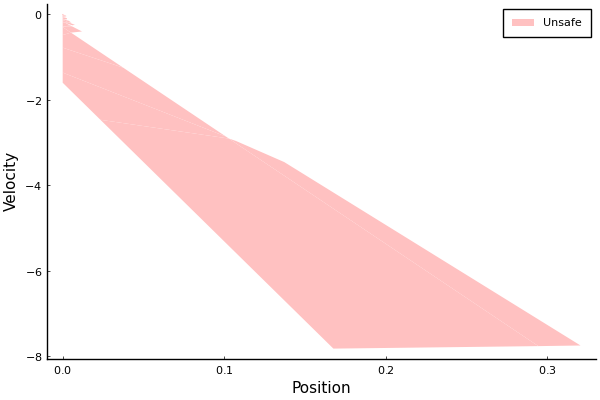

In [13]:
fig_notsafe, acc_notsafe = plot_acc("acc-2000000-64-64-64-64-retrain/results-accretrain.jld";boundsfun=false)
fig_notsafe

In [14]:
store_polys("training/acc_bigger_retrain200000-100000-0.1-polytopes.pickle",get_polytope_list(acc_notsafe.stars))

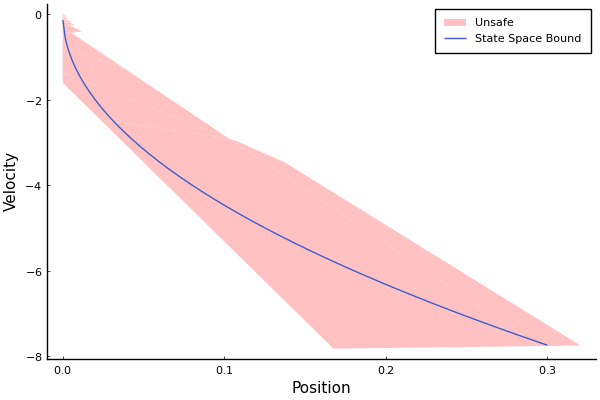

In [15]:
xpts = range(0.0001,0.3, length=200)
fig_notsafe=plot(fig_notsafe,xpts,bound_fun.(xpts),label="State Space Bound",linecolor=:royalblue3)

In [16]:
savefig(fig_notsafe,"acc_retrain_unsafe1.eps")

Dict{String, Any}("approx" => 1, "linear" => false, "output" => "./experiments/acc/acc-2000000-64-64-64-64-retrain/results-accretrain2.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => false, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-2000000-64-64-64-64-retrain-100000-200000-0.9.onnx", "formula" => "test/parsing/examples/acc/formula2", "smt" => "Z3", "smtfilter-timeout" => 10000)

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.32847e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: O

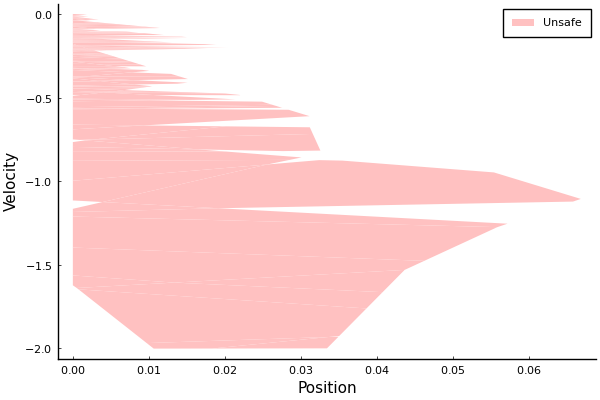

In [17]:
fig_notsafe2, acc_notsafe2 = plot_acc("acc-2000000-64-64-64-64-retrain/results-accretrain2.jld";boundsfun=false)
fig_notsafe2

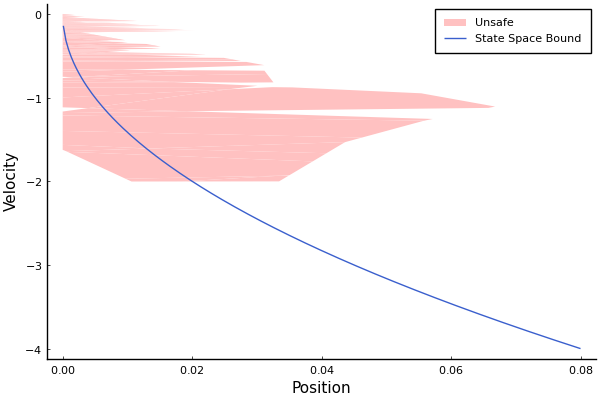

In [18]:
xpts = range(0.0001,0.08, length=200)
fig_notsafe2=plot(fig_notsafe2,xpts,bound_fun.(xpts),label="State Space Bound",linecolor=:royalblue3)

In [19]:
savefig(fig_notsafe2,"acc_retrain_unsafe2.eps")

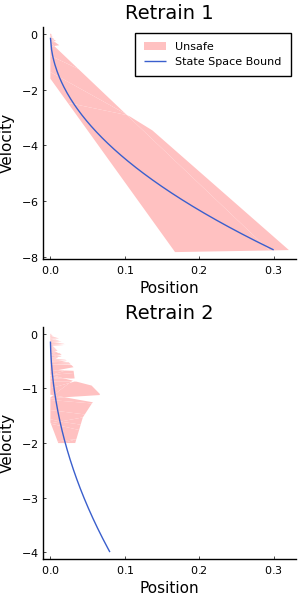

In [20]:
comparison_fig_unsafe = plot(
    plot(fig_notsafe,legend_position=true,title="Retrain 1"),
    plot(fig_notsafe2,legend_position=nothing,title="Retrain 2"),
    layout=(2,1),size = (300, 600),link=:both,left_margin = [0Plots.mm 0Plots.mm])

In [21]:
savefig(comparison_fig_unsafe,"acc_retrain_comparsion.eps")

The result of the second retrain indicates, that we obtain a safe controller when substituting the NN's output with a fallback controller for (`rPos <= 0.08 & -2.1 <= rVel & rVel <= 0.1)`).  
Indeed, we can verify that the network is safe when constraining the input space by `rVel>0.1 | rVel < -2.1 | rPos > 0.08`:

Dict{String, Any}("approx" => 1, "linear" => false, "output" => "./experiments/acc/acc-2000000-64-64-64-64-retrain/results-accretrain2-fallback.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => false, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-2000000-64-64-64-64-retrain-100000-200000-0.9.onnx", "formula" => "test/parsing/examples/acc/formula-fallback", "smt" => "Z3", "smtfilter-timeout" => 10000)

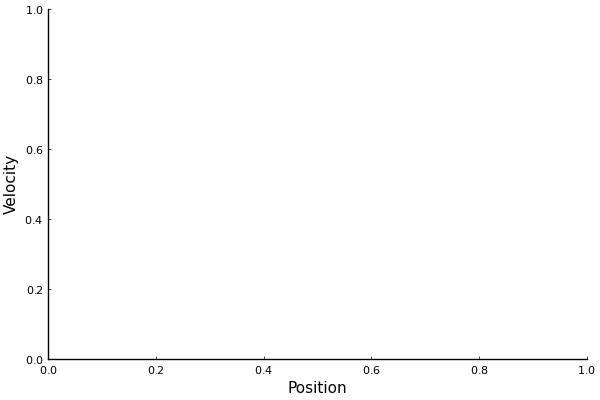

In [49]:
fig_safe_through_fallback, acc_safe_through_fallback = plot_acc("acc-2000000-64-64-64-64-retrain/results-accretrain2-fallback.jld";boundsfun=false)
fig_safe_through_fallback

In [50]:
acc_safe_through_fallback

SNNT.VerifierInterface.OlnnvResult(SNNT.VerifierInterface.Safe, Any[SNNT.SMTInterface.SmtFilterMeta(53, 46), SNNT.SMTInterface.SmtFilterMeta(14, 14), SNNT.SMTInterface.SmtFilterMeta(0, 0), SNNT.SMTInterface.SmtFilterMeta(0, 0), SNNT.SMTInterface.SmtFilterMeta(48, 0), SNNT.SMTInterface.SmtFilterMeta(7, 0), SNNT.SMTInterface.SmtFilterMeta(0, 0), SNNT.SMTInterface.SmtFilterMeta(202, 0), SNNT.SMTInterface.SmtFilterMeta(65, 0), SNNT.SMTInterface.SmtFilterMeta(157, 0), SNNT.SMTInterface.SmtFilterMeta(4, 0), SNNT.SMTInterface.SmtFilterMeta(4, 0), SNNT.SMTInterface.SmtFilterMeta(213, 0), SNNT.SMTInterface.SmtFilterMeta(0, 0)], SNNT.VerifierInterface.Star[])

In [51]:
println("Analyzed stars: ",sum(map(x->x.original_meta,acc_safe_through_fallback.metadata)))
println("Stars inspected through SMT: ",sum(map(x->x.filtered_out,acc_safe_through_fallback.metadata)))

Analyzed stars: 767
Stars inspected through SMT: 60
